In [273]:
from run_on_video.run import MomentDETRPredictor
from IPython.display import display, Image, HTML
import ffmpeg, tempfile, os

In [295]:
def overlaps(t1, t2):
    return t1[0] <= t2[0] <= t1[1] or t1[0] <= t2[1] <= t1[1] or t2[0] <= t1[0] <= t2[1] or t2[0] <= t1[1] <= t2[1]

def overlaps_with_accepted(filtered, highlight):
    for accepted in filtered:
        if overlaps(highlight, accepted):
            return True

    return False

def filter_overlaps(highlights):
    if not highlights:
        return []
    highlights.sort(key=lambda x: x[2], reverse=True)
    filtered = []
    for highlight in highlights:
        if overlaps_with_accepted(filtered, highlight):
            continue
        filtered.append(highlight)

    return filtered

In [296]:
video_path = "sziget/concert_multi.mp4"
queries = ["Visually pleasing and exciting moments for festival after-movie.", "Audience excitement.", "Visually pleasing."]

In [297]:
# run predictions
print("Build models...")
moment_detr_predictor = MomentDETRPredictor(
    ckpt_path="run_on_video/moment_detr_ckpt/model_best.ckpt",
    clip_model_name_or_path="ViT-B/32",
    device="cuda"
)
predictions = moment_detr_predictor.localize_moment(
    video_path=video_path, query_list=queries)

Build models...
Loading feature extractors...
Loading CLIP models


/home/isedlak/.conda/envs/test/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Loading trained Moment-DETR model...


/home/isedlak/projects/moment_detr/moment_detr/position_encoding.py:67: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [298]:
highlights = []
for idx, query in enumerate(queries):
    print("-"*30 + f"idx{idx}")
    print(f">> query: {query}")
    print(f">> video_path: {video_path}")
    print(f">> Predicted moments ([start_in_seconds, end_in_seconds, score]): "
          f"{predictions[idx]['pred_relevant_windows']}")
    highlights += [prediction for prediction in predictions[idx]['pred_relevant_windows'] if prediction[2] >= 0.8]
    highlights += [predictions[idx]['pred_relevant_windows'][0]]

------------------------------idx0
>> query: Visually pleasing and exciting moments for festival after-movie.
>> video_path: sziget/concert_multi.mp4
>> Predicted moments ([start_in_seconds, end_in_seconds, score]): [[11.2963, 19.6449, 0.9765], [6.1832, 11.6612, 0.4193], [3.1337, 9.9141, 0.1426], [0.9786, 6.3875, 0.0622], [4.8837, 11.3117, 0.0228], [5.9646, 16.061, 0.0108], [3.745, 9.2541, 0.0012], [5.2534, 10.1674, 0.0006], [10.0412, 14.601, 0.0004], [8.7326, 13.7668, 0.0003]]
------------------------------idx1
>> query: Audience excitement.
>> video_path: sziget/concert_multi.mp4
>> Predicted moments ([start_in_seconds, end_in_seconds, score]): [[9.6914, 19.2586, 0.9878], [0.1657, 6.3685, 0.986], [7.769, 9.9195, 0.0728], [7.7525, 15.0562, 0.0124], [7.1772, 17.8766, 0.0039], [1.2214, 5.7574, 0.0029], [7.8197, 11.3638, 0.0021], [10.7118, 17.5805, 0.0007], [10.817, 15.2207, 0.0002], [7.0782, 10.4213, 0.0]]
------------------------------idx2
>> query: Visually pleasing.
>> video_path: sz

[11.6132, 19.9122, 0.9881]


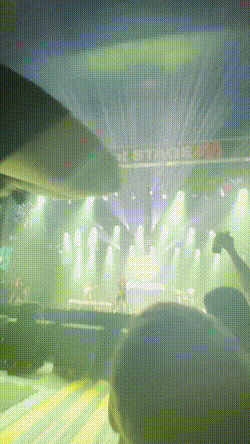

[0.1657, 6.3685, 0.986]


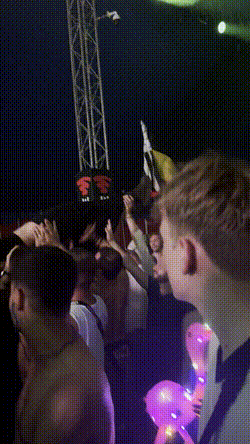

In [299]:
for highlight in filter_overlaps(highlights):
    with tempfile.NamedTemporaryFile(delete=False, suffix='.gif') as temp_file:
        ffmpeg.input(video_path).output(temp_file.name, ss=highlight[0], to=highlight[1], vf="fps=10,scale=250:-1", loglevel="quiet").run(overwrite_output=True)
        print(highlight)
        display(Image(temp_file.name))